## 0. Loading Packages

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
import git
from pathlib import Path
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform_audio import *
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.npyio')

## 1. Select transform type and group

In [2]:
groups = {3: ['normal_intensity', 'strong_intensity'], 4: ['statement_1', 'statement_2'], 6: ['male', 'female']}
group = 3
categories = {3: 'emotional intensity', 4: 'statement', 6: 'gender'}

CATEGORY_NAME = categories[group]
GROUP_NAMES = groups[group]

# Suffix used to construct internal filenames
transform_affix = 'stft'

KS_THRESHOLD = 0.05  

# --- Path Definitions ---
DATA_DIR = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'ravdess-transforms')
PATHS = {
    "Original-Pitch": {
        "coefs_path": os.path.join(DATA_DIR, f'{transform_affix}_coefs.npz'),
        "freqs_path": os.path.join(DATA_DIR, f'{transform_affix}_freqs.npy')
    }
    # "Pitch-Normalized": {
    #     "coefs_path": os.path.join(DATA_DIR, f'{transform_affix}-pn_coefs.npz'),
    #     "freqs_path": os.path.join(DATA_DIR, f'{transform_affix}-pn_freqs.npy')
    # }
}

print("✅ Loaded successfully.")
print(f"Analysis Category: {CATEGORY_NAME.replace('_', ' ').title()} ({GROUP_NAMES[0]} vs {GROUP_NAMES[1]})")
print(f"KS Test Decision Threshold: {KS_THRESHOLD}")

✅ Loaded successfully.
Analysis Category: Emotional Intensity (normal_intensity vs strong_intensity)
KS Test Decision Threshold: 0.05


## 2. Analysis Functions

In [3]:
def load_and_combine_data(coefs_npz_path, group_id, group_map, category_map):
    """
    Loads an NPZ file and merges all internal .npy coefficient files into a single
    DataFrame. This definitive version handles 1D (FFT), 2D (STFT), and 
    jagged object arrays (Erblet).
    """
    print(f"  - Loading and combining data from: {os.path.basename(coefs_npz_path)}")
    category_name = category_map[group_id]
    group_names = group_map[group_id]
    
    all_coeffs_data = []
    # Use allow_pickle=True to handle object arrays
    with np.load(coefs_npz_path, allow_pickle=True) as data:
        for item in data.files:
            try:
                base_filename = item.split('_')[0]
                actor_id = int(base_filename.split('-')[group_id])
                group_label = group_names[1] if actor_id % 2 == 0 else group_names[0]
                
                coeffs = data[item]
                
                if coeffs.ndim == 2:
                    for freq_idx in range(coeffs.shape[0]):
                        for coeff_val in coeffs[freq_idx, :]:
                            all_coeffs_data.append({
                                category_name: group_label, 'freq_index': freq_idx,
                                'coefficient_real': np.real(coeff_val), 'coefficient_imag': np.imag(coeff_val)
                            })
                
                elif coeffs.ndim == 1:
                    if coeffs.dtype == object: 
                        for freq_idx, inner_array in enumerate(coeffs):
                            # Check if the element is actually an iterable array
                            if hasattr(inner_array, '__iter__'):
                                for coeff_val in inner_array:
                                    all_coeffs_data.append({
                                        category_name: group_label, 'freq_index': freq_idx,
                                        'coefficient_real': np.real(coeff_val), 'coefficient_imag': np.imag(coeff_val)
                                    })
                            else: # Failsafe for single numbers within the object array
                                all_coeffs_data.append({
                                    category_name: group_label, 'freq_index': freq_idx,
                                    'coefficient_real': np.real(inner_array), 'coefficient_imag': np.imag(inner_array)
                                })
                    else:
                        for freq_idx, coeff_val in enumerate(coeffs):
                            all_coeffs_data.append({
                                category_name: group_label, 'freq_index': freq_idx,
                                'coefficient_real': np.real(coeff_val), 'coefficient_imag': np.imag(coeff_val)
                            })
                else:
                    print(f"  - Warning: Skipping item '{item}' with unsupported shape {coeffs.shape}")
                    continue

            except (ValueError, IndexError) as e:
                print(f"  - Warning: Could not parse filename '{item}', skipped. Error: {e}")
                continue
                
    if not all_coeffs_data:
        print("❗️Warning: Could not load any coefficient data from NPZ file. Please check file formats and group_id.")

    return pd.DataFrame(all_coeffs_data)

def compare_distributions_by_band(full_df, unified_bands_indices, category_name, group_names):
    """
    Compares the coefficient distributions of two groups band by band under a unified banding scheme.
    """
    if category_name not in full_df.columns:
        raise KeyError(f"Error: Column '{category_name}' not found in DataFrame. Please check the load_and_combine_data function.")

    print(f"  - Performing KS test band by band ({group_names[0]} vs {group_names[1]})...")

    group1_df = full_df[full_df[category_name] == group_names[0]]
    group2_df = full_df[full_df[category_name] == group_names[1]]
    
    results = []
    for start_idx, end_idx in unified_bands_indices:
        group1_in_band = group1_df[(group1_df['freq_index'] >= start_idx) & (group1_df['freq_index'] < end_idx)]
        group2_in_band = group2_df[(group2_df['freq_index'] >= start_idx) & (group2_df['freq_index'] < end_idx)]
        
        if len(group1_in_band) < 30 or len(group2_in_band) < 30: continue

        ks_stat_real, _ = ks_2samp(group1_in_band['coefficient_real'], group2_in_band['coefficient_real'])
        ks_stat_imag, _ = ks_2samp(group1_in_band['coefficient_imag'], group2_in_band['coefficient_imag'])
        
        results.append({
            'band_indices': f'{start_idx}-{end_idx - 1}' if end_idx > start_idx + 1 else str(start_idx),
            'ks_stat_real': ks_stat_real,
            'ks_stat_imag': ks_stat_imag,
        })
            
    return pd.DataFrame(results)

def group_coeffs_by_band(subgroup_df, unified_bands_indices):
    """
    Groups all coefficients from a subgroup DataFrame based on a unified band division.
    """
    band_coeffs_data = {}

    for start_idx, end_idx in unified_bands_indices:
        band_label = f'{start_idx}-{end_idx - 1}' if end_idx > start_idx + 1 else str(start_idx)
         
        df_in_band = subgroup_df[(subgroup_df['freq_index'] >= start_idx) & (subgroup_df['freq_index'] < end_idx)]
         
        if df_in_band.empty:
            real_coeffs, imag_coeffs = np.array([]), np.array([])
        else:
            real_coeffs = df_in_band['coefficient_real'].values
            imag_coeffs = df_in_band['coefficient_imag'].values
             
        band_coeffs_data[band_label] = {
            'real': real_coeffs,
            'imag': imag_coeffs
        }
             
    return band_coeffs_data

## 3. Distribution Analysis

In [ ]:
all_results = {}
all_files_exist = True

for experiment_name, paths in PATHS.items():
    print(f"\n{'='*20} Starting Experiment: {experiment_name} {'='*20}")
    
    # Check if files exist
    if not os.path.exists(paths["coefs_path"]) or not os.path.exists(paths["freqs_path"]):
        print(f"❗️Error: Cannot find file {paths['coefs_path']} or {paths['freqs_path']}.")
        all_files_exist = False
        break

    print("  - Counting files per group...")
    try:
        with np.load(paths["coefs_path"]) as data:
            # Initialize a dictionary to hold the counts
            file_counts = {name: 0 for name in GROUP_NAMES}
            
            # Iterate through all the .npy files within the .npz archive
            for item in data.files:
                try:
                    base_filename = item.split('_')[0]
                    actor_id = int(base_filename.split('-')[group])
                    group_label = GROUP_NAMES[1] if actor_id % 2 == 0 else GROUP_NAMES[0]
                    file_counts[group_label] += 1
                except (ValueError, IndexError):
                    # This handles cases where a filename doesn't match the expected format
                    continue
        
        # Print the summary of file counts
        for group_name, count in file_counts.items():
            print(f"    - Found {count} files for '{group_name.title()}'")
    except Exception as e:
        print(f"  - ❗️Could not count files due to an error: {e}")

    # Step 1: Calculate unified frequency bands on the combined dataset
    print("  - Calculating unified frequency bands...")
    unified_band_indices = freq_band_groupings(
        coefs_npz_path=paths["coefs_path"],
        ks_threshold=KS_THRESHOLD,
        presplit_depth=1
    )
    print(f"  - Unified banding complete. Found {len(unified_band_indices)} bands.")
    
    # Step 2: Load the data into a single DataFrame
    full_df = load_and_combine_data(paths["coefs_path"], group, groups, categories)

    # Step 3: Compare distributions within the unified bands
    if not full_df.empty:
        comparison_df = compare_distributions_by_band(full_df, unified_band_indices, CATEGORY_NAME, GROUP_NAMES)
        all_results[experiment_name] = comparison_df
    else:
        all_results[experiment_name] = pd.DataFrame()

    print(f"✅ Experiment {experiment_name} complete.")


==================== Starting Experiment: Original-Pitch ====================
  - Counting files per group...
    - Found 768 files for 'Normal_Intensity'
    - Found 672 files for 'Strong_Intensity'
  - Calculating unified frequency bands...
  - Unified banding complete. Found 10 bands.
  - Loading and combining data from: stft_coefs.npz
  - Performing KS test band by band (normal_intensity vs strong_intensity)...
✅ Experiment Original-Pitch complete.

==================== Starting Experiment: Pitch-Normalized ====================
  - Counting files per group...
    - Found 768 files for 'Normal_Intensity'
    - Found 672 files for 'Strong_Intensity'
  - Calculating unified frequency bands...
  - Unified banding complete. Found 15 bands.
  - Loading and combining data from: stft-pn_coefs.npz
  - Performing KS test band by band (normal_intensity vs strong_intensity)...
✅ Experiment Pitch-Normalized complete.


## 4. Results and Visualization


############################################################
### Analysis Report: Emotional Intensity ###
############################################################

--- Results for: Original-Pitch (normal_intensity vs strong_intensity) ---
In 10 bands, 1 have a difference greater than the threshold 0.05.
band_indices  ks_stat_real  ks_stat_imag
        0-15         0.052         0.051
       16-31         0.023         0.023
       32-63         0.009         0.009
       64-95         0.010         0.010
      96-127         0.012         0.012
     128-255         0.017         0.017
     256-319         0.015         0.015
     320-383         0.022         0.022
     384-447         0.022         0.022
     448-512         0.033         0.032


--- Results for: Pitch-Normalized (normal_intensity vs strong_intensity) ---
In 15 bands, 2 have a difference greater than the threshold 0.05.
band_indices  ks_stat_real  ks_stat_imag
        0-31         0.022         0.022
       32-63

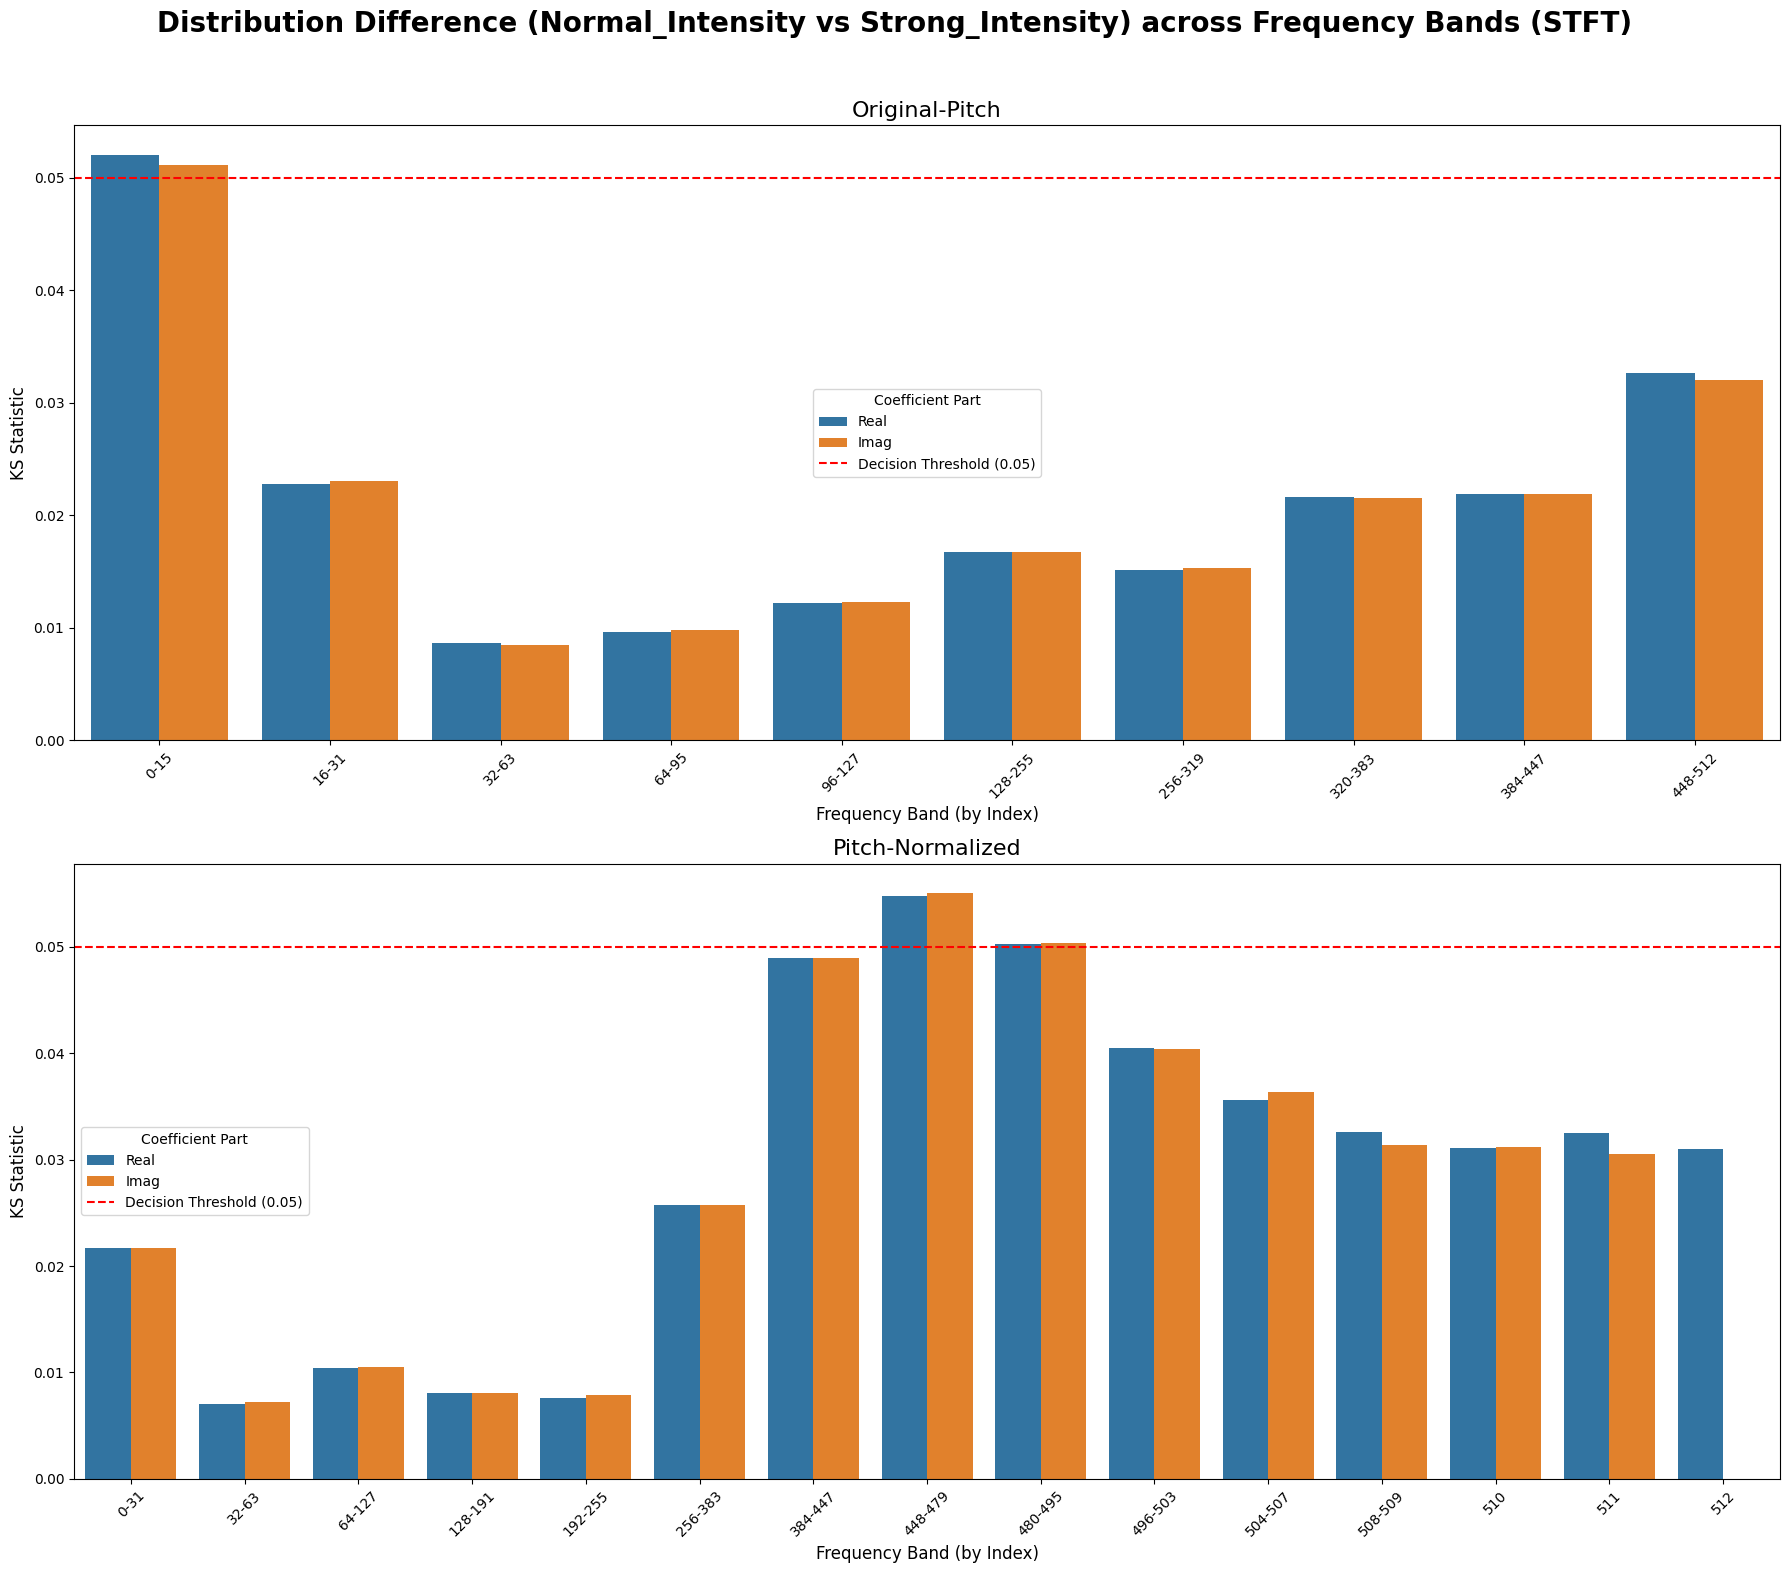

In [5]:
if not all_files_exist:
    print("\n❗️Analysis could not be completed due to missing files. Cannot generate report.")
else:
    print("\n" + "#"*60)
    print(f"### Analysis Report: {CATEGORY_NAME.replace('_', ' ').title()} ###")
    print("#"*60 + "\n")
    
    for experiment_name, result_df in all_results.items():
        print(f"--- Results for: {experiment_name} ({GROUP_NAMES[0]} vs {GROUP_NAMES[1]}) ---")
        if result_df.empty:
            print("  - No results to display for this experiment.")
            continue
        
        significant_diffs = result_df[
            (result_df['ks_stat_real'] > KS_THRESHOLD) | 
            (result_df['ks_stat_imag'] > KS_THRESHOLD)
        ]
        print(f"In {len(result_df)} bands, {len(significant_diffs)} have a difference greater than the threshold {KS_THRESHOLD}.")
        print(result_df.round(3).to_string(index=False))
        print("\n")

    # --- Visualization ---
    fig, axes = plt.subplots(len(all_results), 1, figsize=(18, 8 * len(all_results)), sharex=False)
    if len(all_results) == 1: axes = [axes]
    fig.suptitle(f'Distribution Difference ({GROUP_NAMES[0].title()} vs {GROUP_NAMES[1].title()}) across Frequency Bands ({transform_affix.upper()})', fontsize=20, weight='bold')

    for ax, (experiment_name, result_df) in zip(axes, all_results.items()):
        if result_df.empty:
            ax.text(0.5, 0.5, 'No data to plot for this experiment.', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(experiment_name, fontsize=16)
            continue
        
        plot_df = result_df.melt(
            id_vars=['band_indices'], 
            value_vars=['ks_stat_real', 'ks_stat_imag'],
            var_name='Coefficient Part',
            value_name='KS Statistic'
        )
        plot_df['Coefficient Part'] = plot_df['Coefficient Part'].str.replace('ks_stat_', '').str.title()
        
        # Create the bar plot
        sns.barplot(ax=ax, data=plot_df, x='band_indices', y='KS Statistic', hue='Coefficient Part')
        
        # Add the decision threshold line
        ax.axhline(y=KS_THRESHOLD, color='r', linestyle='--', label=f'Decision Threshold ({KS_THRESHOLD})')
        
        ax.set_title(experiment_name, fontsize=16)
        ax.set_xlabel('Frequency Band (by Index)', fontsize=12)
        ax.set_ylabel('KS Statistic', fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Coefficient Part')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## 5. Unified Bands & Subdivision

In [ ]:
all_subdivided_data = {}
all_files_exist = True

for experiment_name, paths in PATHS.items():
    print(f"\n{'='*20} Starting Experiment: {experiment_name} {'='*20}")
    
    if not os.path.exists(paths["coefs_path"]) or not os.path.exists(paths["freqs_path"]):
        print(f"❗️Error: File not found {paths['coefs_path']} or {paths['freqs_path']}.")
        all_files_exist = False
        break

    print("  - Step 1: Calculating unified frequency bands on all data...")
    unified_band_indices = freq_band_groupings(
        coefs_npz_path=paths["coefs_path"],
        ks_threshold=KS_THRESHOLD,
        presplit_depth=1
    )
    print(f"  - Unified band division complete. Found {len(unified_band_indices)} bands in total.")
    
    # --- Step 2: Load all data into a DataFrame ---
    print("  - Step 2: Loading all data...")
    full_df = load_and_combine_data(paths["coefs_path"], group, groups, categories)
    
    if full_df.empty:
        print(f"  - ❗️ No data loaded for {experiment_name}, skipping this experiment.")
        all_subdivided_data[experiment_name] = {}
        continue

    # --- Step 3: Perform data subdivision and process each subgroup separately ---
    print(f"  - Step 3: Subdividing and processing data by '{CATEGORY_NAME}'...")
    
    experiment_results = {} # To store the subdivision results of the current experiment, e.g., {'male': {...}, 'female': {...}}
    
    # GROUP_NAMES is defined in the configuration, e.g., ['male', 'female']
    for group_name in GROUP_NAMES:
        print(f"    - Processing subgroup: {group_name}")
        
        # Filter data for the current group from full_df
        subgroup_df = full_df[full_df[CATEGORY_NAME] == group_name].copy()
        
        if subgroup_df.empty:
            print(f"    - ❗️ Subgroup {group_name} has no data, skipping.")
            experiment_results[group_name] = {}
            continue
            
        # --- Step 4: Process the [current subgroup's] data using the [unified band standard] ---
        subgroup_coeffs_by_band = group_coeffs_by_band(
            subgroup_df, 
            unified_band_indices
        )
        
        # Store the processing result in the dictionary for the current experiment
        experiment_results[group_name] = subgroup_coeffs_by_band

    # Store the complete subdivision results of this experiment into the final main dictionary
    all_subdivided_data[experiment_name] = experiment_results
    print(f"✅ Data subdivision processing for experiment {experiment_name} is complete.")


==================== Starting Experiment: Original-Pitch ====================
  - Step 1: Calculating unified frequency bands on all data...
  - Unified band division complete. Found 10 bands in total.
  - Step 2: Loading all data...
  - Loading and combining data from: stft_coefs.npz
  - Step 3: Subdividing and processing data by 'emotional intensity'...
    - Processing subgroup: normal_intensity
    - Processing subgroup: strong_intensity
✅ Data subdivision processing for experiment Original-Pitch is complete.


## 6. Save to Pickcle

In [5]:
if all_files_exist and all_subdivided_data:
    output_filename = f'ravdess_oriPitch_{transform_affix}_{CATEGORY_NAME.replace(" ", "_")}.pickle'
    print(f"\n{'='*20} Saving Final Results {'='*20}")
    print(f"  - Saving all subdivided coefficient data to: {output_filename} ...")

    with open(output_filename, 'wb') as file:
        pickle.dump(all_subdivided_data, file)

    print("✅ Data saved successfully!")
else:
    print("\n❗️No output file was generated due to missing files or no data being processed.")


==================== Saving Final Results ====================
  - Saving all subdivided coefficient data to: ravdess_oriPitch_stft_emotional_intensity.pickle ...
✅ Data saved successfully!


## 7. Load and verify the saved pickle file (Optional)

In [6]:
try:
    # Make sure the filename is consistent with the one used for saving above
    verify_filename = f'ravdess_oriPitch_{transform_affix}_{CATEGORY_NAME.replace(" ", "_")}.pickle'
    print(f"\n{'='*20} Verifying the Saved File {'='*20}")
    print(f"  - Loading data from {verify_filename}...")

    with open(verify_filename, 'rb') as file:
        loaded_data = pickle.load(file)
    
    print("  - Data loaded successfully! Starting to check the internal structure...")

    # Check top-level keys
    print("\n  1. Top-level keys:")
    print(f"     {list(loaded_data.keys())}")

    # Check keys within an experiment (group names)
    first_experiment = list(loaded_data.keys())[0]
    print(f"\n  2. Keys under the '{first_experiment}' experiment (group names):")
    print(f"     {list(loaded_data[first_experiment].keys())}")

    # Check keys within a group (band labels)
    first_group = list(loaded_data[first_experiment].keys())[0]
    print(f"\n  3. First 10 band labels under the '{first_group}' group:")
    print(f"     {list(loaded_data[first_experiment][first_group].keys())[:10]}")

    # Check the data structure within a band
    first_band = list(loaded_data[first_experiment][first_group].keys())[0]
    print(f"\n  4. Data structure under band '{first_band}' (coefficient types):")
    print(f"     {list(loaded_data[first_experiment][first_group][first_band].keys())}")

    # Check the final coefficient data
    real_coeffs = loaded_data[first_experiment][first_group][first_band]['real']
    print(f"\n  5. Final data spot check:")
    print(f"     Inside '{first_experiment}' -> '{first_group}' -> '{first_band}' -> 'real', ")
    print(f"     we found a Numpy array with shape: {real_coeffs.shape}")
    print("✅ Verification passed!")

except FileNotFoundError:
    print(f"\n❗️Verification failed: Cannot find file '{verify_filename}'. Please ensure the code above has run successfully.")
except Exception as e:
    print(f"\n❗️An unknown error occurred during verification: {e}")


==================== Verifying the Saved File ====================
  - Loading data from ravdess_oriPitch_stft_emotional_intensity.pickle...
  - Data loaded successfully! Starting to check the internal structure...

  1. Top-level keys:
     ['Original-Pitch']

  2. Keys under the 'Original-Pitch' experiment (group names):
     ['normal_intensity', 'strong_intensity']

  3. First 10 band labels under the 'normal_intensity' group:
     ['0-15', '16-31', '32-63', '64-95', '96-127', '128-255', '256-319', '320-383', '384-447', '448-512']

  4. Data structure under band '0-15' (coefficient types):
     ['real', 'imag']

  5. Final data spot check:
     Inside 'Original-Pitch' -> 'normal_intensity' -> '0-15' -> 'real', 
     we found a Numpy array with shape: (3626288,)
✅ Verification passed!


## 5. Unified Bands & Subdivision (geometric)


==================== Starting Experiment: Original-Pitch ====================
  - Step 1: Calculating unified frequency bands on all data...
  - Unified band division complete. Found 10 bands in total.
  - Regularizing bands to a geometric scale...


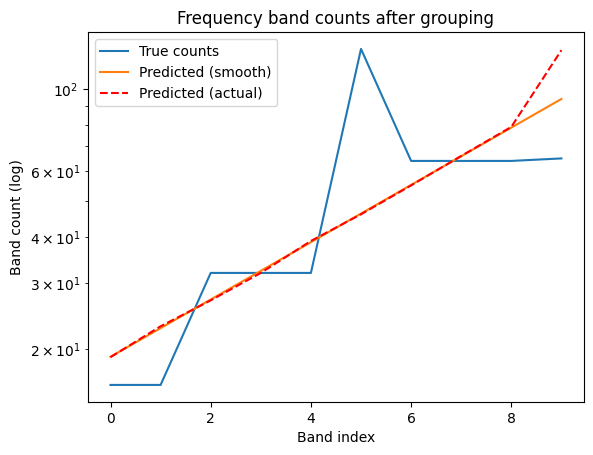

  - Regularization complete. New band count: 10
  - Step 2: Loading all data...
  - Loading and combining data from: stft_coefs.npz
  - Step 3: Subdividing and processing data by 'emotional intensity'...
    - Processing subgroup: normal_intensity
    - Processing subgroup: strong_intensity
✅ Data subdivision processing for experiment Original-Pitch is complete.


In [4]:
all_subdivided_data = {}
all_files_exist = True

for experiment_name, paths in PATHS.items():
    print(f"\n{'='*20} Starting Experiment: {experiment_name} {'='*20}")
    
    if not os.path.exists(paths["coefs_path"]) or not os.path.exists(paths["freqs_path"]):
        print(f"❗️Error: File not found {paths['coefs_path']} or {paths['freqs_path']}.")
        all_files_exist = False
        break

    print("  - Step 1: Calculating unified frequency bands on all data...")
    unified_band_indices = freq_band_groupings(
        coefs_npz_path=paths["coefs_path"],
        ks_threshold=KS_THRESHOLD,
        presplit_depth=1
    )
    print(f"  - Unified band division complete. Found {len(unified_band_indices)} bands in total.")
    
    print("  - Regularizing bands to a geometric scale...")
    geometric_bands = geometric_count_bands(unified_band_indices, visualize=True)
    print(f"  - Regularization complete. New band count: {len(geometric_bands)}")

    # --- Step 2: Load all data into a DataFrame ---
    print("  - Step 2: Loading all data...")
    full_df = load_and_combine_data(paths["coefs_path"], group, groups, categories)
    
    if full_df.empty:
        print(f"  - ❗️ No data loaded for {experiment_name}, skipping this experiment.")
        all_subdivided_data[experiment_name] = {}
        continue

    # --- Step 3: Perform data subdivision and process each subgroup separately ---
    print(f"  - Step 3: Subdividing and processing data by '{CATEGORY_NAME}'...")
    
    experiment_results = {} # To store the subdivision results of the current experiment, e.g., {'male': {...}, 'female': {...}}
    
    # GROUP_NAMES is defined in the configuration, e.g., ['male', 'female']
    for group_name in GROUP_NAMES:
        print(f"    - Processing subgroup: {group_name}")
        
        # Filter data for the current group from full_df
        subgroup_df = full_df[full_df[CATEGORY_NAME] == group_name].copy()
        
        if subgroup_df.empty:
            print(f"    - ❗️ Subgroup {group_name} has no data, skipping.")
            experiment_results[group_name] = {}
            continue
            
        # --- Step 4: Process the [current subgroup's] data using the [unified band standard] ---
        subgroup_coeffs_by_band = group_coeffs_by_band(
            subgroup_df, 
            geometric_bands  # <-- geometric_bands
        )
        
        # Store the processing result in the dictionary for the current experiment
        experiment_results[group_name] = subgroup_coeffs_by_band

    # Store the complete subdivision results of this experiment into the final main dictionary
    all_subdivided_data[experiment_name] = experiment_results
    print(f"✅ Data subdivision processing for experiment {experiment_name} is complete.")

## 6. Save to Pickcle (geometric)

In [5]:
if all_files_exist and all_subdivided_data:
    output_filename = f'ravdess_oriPitch_{transform_affix}_{CATEGORY_NAME.replace(" ", "_")}_geometric.pickle'
    print(f"\n{'='*20} Saving Final Results {'='*20}")
    print(f"  - Saving all subdivided coefficient data to: {output_filename} ...")

    with open(output_filename, 'wb') as file:
        pickle.dump(all_subdivided_data, file)

    print("✅ Data saved successfully!")
else:
    print("\n❗️No output file was generated due to missing files or no data being processed.")


==================== Saving Final Results ====================
  - Saving all subdivided coefficient data to: ravdess_oriPitch_stft_emotional_intensity_geometric.pickle ...
✅ Data saved successfully!


## 7. Load and verify the saved pickle file (Optional)

In [6]:
try:
    # Make sure the filename is consistent with the one used for saving above
    verify_filename = f'ravdess_oriPitch_{transform_affix}_{CATEGORY_NAME.replace(" ", "_")}_geometric.pickle'
    print(f"\n{'='*20} Verifying the Saved File {'='*20}")
    print(f"  - Loading data from {verify_filename}...")

    with open(verify_filename, 'rb') as file:
        loaded_data = pickle.load(file)
    
    print("  - Data loaded successfully! Starting to check the internal structure...")

    # Check top-level keys
    print("\n  1. Top-level keys:")
    print(f"     {list(loaded_data.keys())}")

    # Check keys within an experiment (group names)
    first_experiment = list(loaded_data.keys())[0]
    print(f"\n  2. Keys under the '{first_experiment}' experiment (group names):")
    print(f"     {list(loaded_data[first_experiment].keys())}")

    # Check keys within a group (band labels)
    first_group = list(loaded_data[first_experiment].keys())[0]
    print(f"\n  3. First 10 band labels under the '{first_group}' group:")
    print(f"     {list(loaded_data[first_experiment][first_group].keys())[:10]}")

    # Check the data structure within a band
    first_band = list(loaded_data[first_experiment][first_group].keys())[0]
    print(f"\n  4. Data structure under band '{first_band}' (coefficient types):")
    print(f"     {list(loaded_data[first_experiment][first_group][first_band].keys())}")

    # Check the final coefficient data
    real_coeffs = loaded_data[first_experiment][first_group][first_band]['real']
    print(f"\n  5. Final data spot check:")
    print(f"     Inside '{first_experiment}' -> '{first_group}' -> '{first_band}' -> 'real', ")
    print(f"     we found a Numpy array with shape: {real_coeffs.shape}")
    print("✅ Verification passed!")

except FileNotFoundError:
    print(f"\n❗️Verification failed: Cannot find file '{verify_filename}'. Please ensure the code above has run successfully.")
except Exception as e:
    print(f"\n❗️An unknown error occurred during verification: {e}")


==================== Verifying the Saved File ====================
  - Loading data from ravdess_oriPitch_stft_emotional_intensity_geometric.pickle...
  - Data loaded successfully! Starting to check the internal structure...

  1. Top-level keys:
     ['Original-Pitch']

  2. Keys under the 'Original-Pitch' experiment (group names):
     ['normal_intensity', 'strong_intensity']

  3. First 10 band labels under the 'normal_intensity' group:
     ['0-18', '19-41', '42-68', '69-100', '101-139', '140-185', '186-240', '241-306', '307-385', '386-512']

  4. Data structure under band '0-18' (coefficient types):
     ['real', 'imag']

  5. Final data spot check:
     Inside 'Original-Pitch' -> 'normal_intensity' -> '0-18' -> 'real', 
     we found a Numpy array with shape: (4306217,)
✅ Verification passed!
